In [1]:
from portfolio_optimization.data_processing import *
from portfolio_optimization.data_collection import *
from datetime import datetime, timezone, timedelta
from tokens.get_assets import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pypfopt
from pypfopt import risk_models, plotting

In [2]:
asset_list = get_tickers()
_df = get_historical_prices_for_assets(asset_list['high_risk_tickers'], time_range=timedelta(days=365 * 3), interested_columns=["ReferenceRate", "CapMrktEstUSD"])

# Filter out all columns containing `_` in their name
df = _df.loc[:, ~_df.columns.str.contains("_")]

# Get all the market caps
mcaps = _df.loc[:, _df.columns.str.contains("CapMrktEstUSD")]
mcaps.columns = mcaps.columns.str.replace("_CapMrktEstUSD", "")
mcaps.replace(np.nan, 0, inplace=True)
# Print comprehensive statistical summary
df

High risk tickers: 14
Medium risk tickers: 60
Low risk tickers: 8


/Users/arguiot/Developer/Pyratz/portfolio/portfolio_optimization/data_collection/get_crypto_price_range.py:41: DtypeWarning: Columns (146) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file)
/var/folders/d2/1qh2h9ys19z3375prb_0cb8w0000gn/T/ipykernel_35389/3080830945.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcaps.replace(np.nan, 0, inplace=True)


,aave,ada,avax,btc,cake,dot,eth,link,matic,sol,uni,bnb,wbtc
2020-07-31,NaN,0.141061,NaN,11135.390726,NaN,NaN,335.964083,7.442294,0.020463,1.688343,NaN,20.042924,10854.381868
2020-08-01,NaN,0.139477,NaN,11338.197341,NaN,NaN,346.179992,7.778109,0.020328,1.542677,NaN,20.663582,11295.000000
2020-08-02,NaN,0.145387,NaN,11797.582127,NaN,NaN,387.185885,8.382811,0.021058,1.536201,NaN,21.587749,11986.082006
2020-08-03,NaN,0.133972,NaN,11094.020684,NaN,NaN,372.180672,8.273066,0.020082,1.728753,NaN,20.889776,11014.108986
2020-08-04,NaN,0.137087,NaN,11236.095681,NaN,NaN,385.487812,9.094514,0.020526,1.799026,NaN,21.911123,10751.489605
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-27,72.024414,0.306618,13.258232,29361.591758,1.480110,5.236669,1871.168158,7.752525,0.722021,25.193344,5.841330,238.864419,29380.545409
2023-07-28,72.314889,0.307404,13.138135,29201.686518,1.495088,5.229932,1859.041747,7.984037,0.716054,25.099691,5.863019,240.365195,29216.897974
2023-07-29,72.863904,0.310223,13.237402,29316.313075,1.513606,5.215896,1875.015270,7.795954,0.709783,24.869877,6.008134,241.931725,29307.518181
2023-07-30,74.595400,0.312831,13.247351,29360.376179,1.509862,5.250953,1881.002765,7.860116,0.718696,25.197212,6.331960,242.479726,29366.248254


,aave,ada,avax,btc,cake,dot,eth,link,matic,sol,uni,bnb,wbtc
aave,1.000000,0.802705,0.334506,0.822493,0.924344,0.865417,0.586702,0.936148,0.218855,0.343635,0.953896,0.464383,0.822510
ada,0.802705,1.000000,0.583193,0.822944,0.849985,0.853682,0.835698,0.774807,0.608147,0.721360,0.832183,0.722686,0.822950
avax,0.334506,0.583193,1.000000,0.662112,0.307879,0.627566,0.827888,0.414033,0.736660,0.890685,0.345326,0.712956,0.662098
btc,0.822493,0.822944,0.662112,1.000000,0.775395,0.935276,0.842699,0.812118,0.502374,0.665868,0.838059,0.726733,0.999927
cake,0.924344,0.849985,0.307879,0.775395,1.000000,0.832797,0.648954,0.933413,0.253451,0.412125,0.939951,0.718473,0.775275
dot,0.865417,0.853682,0.627566,0.935276,0.832797,1.000000,0.772878,0.910693,0.424674,0.670762,0.895130,0.664911,0.935457
eth,0.586702,0.835698,0.827888,0.842699,0.648954,0.772878,1.000000,0.588554,0.834861,0.874961,0.629217,0.905978,0.842471
link,0.936148,0.774807,0.414033,0.812118,0.933413,0.910693,0.588554,1.000000,0.230822,0.437109,0.935641,0.463570,0.812788
matic,0.218855,0.608147,0.736660,0.502374,0.253451,0.424674,0.834861,0.230822,1.000000,0.761888,0.289210,0.834031,0.501843
sol,0.343635,0.721360,0.890685,0.665868,0.412125,0.670762,0.874961,0.437109,0.761888,1.000000,0.394723,0.740354,0.665921


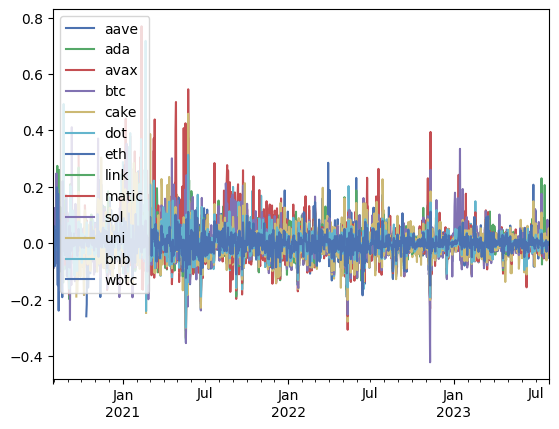

In [3]:
# this will give you the percentage change
df_percentage_variation = df.pct_change()

# plot variation of each asset's price
df_percentage_variation.plot()
pd.DataFrame(df).corr()

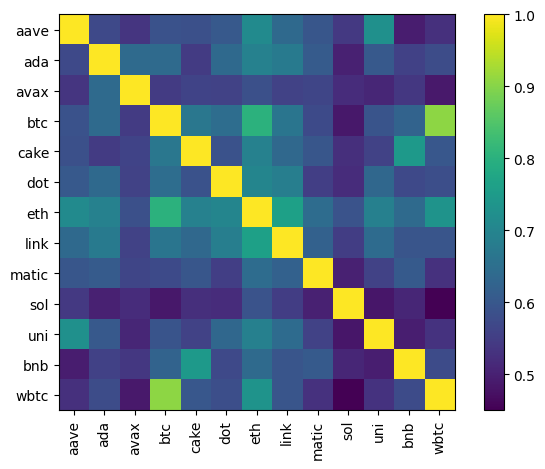

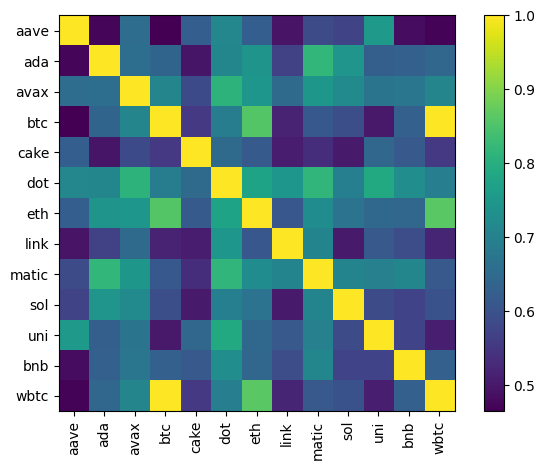

In [4]:
past_df, future_df = df.iloc[:-100], df.iloc[-100:]
future_cov = risk_models.sample_cov(future_df).fillna(0)
sample_cov = risk_models.sample_cov(past_df).fillna(0)

plotting.plot_covariance(sample_cov, plot_correlation=True)
plotting.plot_covariance(future_cov, plot_correlation=True)
plt.show()

In [5]:
rets = expected_returns(df)
rets.tail()

,aave,ada,avax,btc,cake,dot,eth,link,matic,sol,uni,bnb,wbtc
2023-07-27,0.027832,0.009084,-0.006083,0.004803,-0.001103,0.012234,0.007329,0.047013,0.020361,0.083558,0.008839,0.004732,0.005475
2023-07-28,0.004033,0.002565,-0.009058,-0.005446,0.010119,-0.001287,-0.006481,0.029863,-0.008265,-0.003717,0.003713,0.006283,-0.005570
2023-07-29,0.007592,0.009168,0.007556,0.003925,0.012386,-0.002684,0.008592,-0.023557,-0.008757,-0.009156,0.024751,0.006517,0.003102
2023-07-30,0.023763,0.008407,0.000752,0.001503,-0.002474,0.006721,0.003193,0.008230,0.012557,0.013162,0.053898,0.002265,0.002004
2023-07-31,-0.051317,0.004585,-0.009196,-0.003322,-0.008931,-0.012994,-0.010365,-0.039472,-0.029598,-0.037336,0.012214,-0.000024,-0.002804


In [6]:
# exp_cov = risk_models.exp_cov(past_df)
# plotting.plot_covariance(exp_cov, plot_correlation=True)
# plotting.plot_covariance(future_cov, plot_correlation=True)
# plt.show()

Optimization
================

/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/portfolio_optimization/optimization/black_litterman.py:152: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


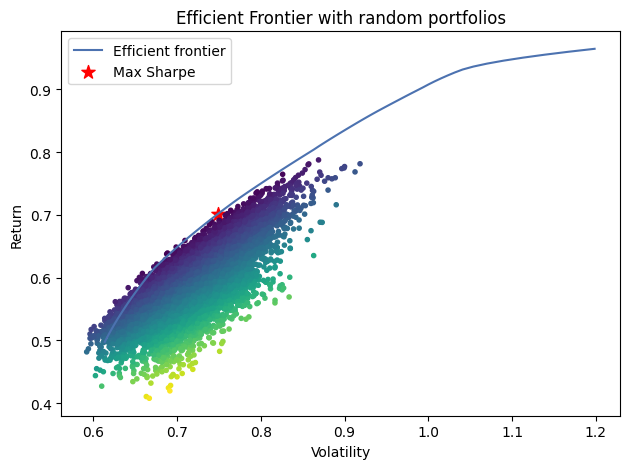

Inequality constraints incompatible    (Exit mode 4)
            Current function value: nan
            Iterations: 1
            Function evaluations: 14
            Gradient evaluations: 1


In [7]:
from portfolio_optimization.optimization.hrp import HRPOptimization
from portfolio_optimization.optimization.markowitz import Markowitz
from portfolio_optimization.optimization.black_litterman import BlackLitterman
from portfolio_optimization.optimization.risk_parity import RiskParity
from portfolio_optimization.optimization.heuristic import FastRiskParity, Heuristic, RewardToRisk, VolatilityOfVolatility
hrp = HRPOptimization(df, rets=rets)
hrp_weights = hrp.get_weights()

markowitz = Markowitz(df)
markowitz_weights = markowitz.get_weights()

last_mcaps = mcaps.iloc[-2]

bl = BlackLitterman(df, mcaps=last_mcaps)
bl_weights = bl.get_weights()
bl.plot_frontier()

rp = RiskParity(df)
rp_weights = rp.get_weights()

fast_rp = FastRiskParity(df)
fast_rp_weights = fast_rp.get_weights()

rtr = RewardToRisk(df)
rtr_weights = rtr.get_weights()

vov = VolatilityOfVolatility(df)
vov_weights = vov.get_weights()

heuristic = Heuristic(df)
heuristic_weights = heuristic.get_weights()

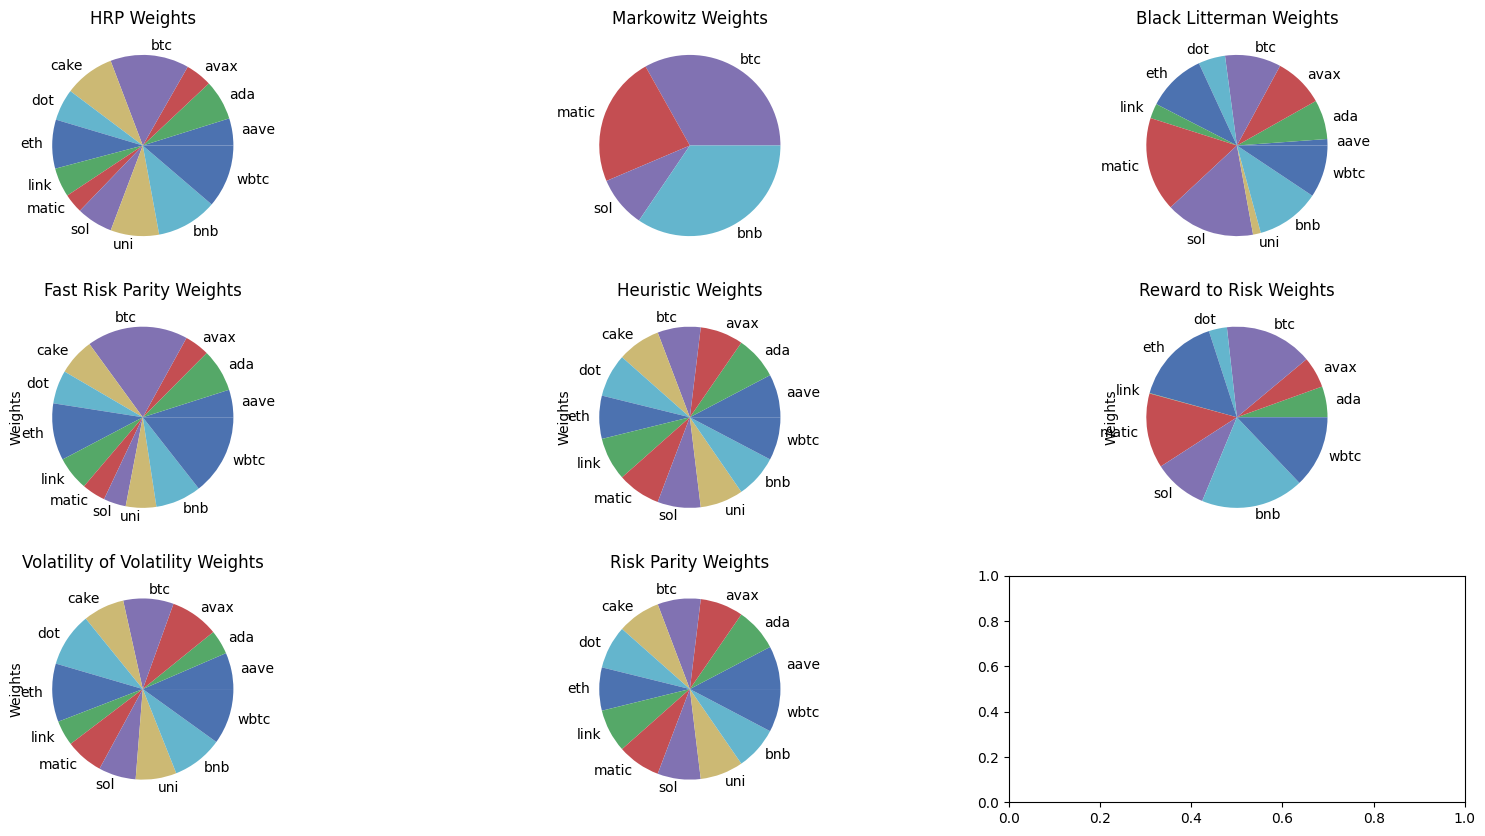

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(20, 10))

pd.Series(hrp_weights).plot.pie(ax=axs[0][0]);
axs[0][0].set_title('HRP Weights')

pd.Series(markowitz_weights).plot.pie(ax=axs[0][1]);
axs[0][1].set_title('Markowitz Weights')

pd.Series(bl_weights).plot.pie(ax=axs[0][2]);
axs[0][2].set_title('Black Litterman Weights')

pd.Series(fast_rp_weights).plot.pie(ax=axs[1][0]);
axs[1][0].set_title('Fast Risk Parity Weights')

pd.Series(heuristic_weights).plot.pie(ax=axs[1][1]);
axs[1][1].set_title('Heuristic Weights')

pd.Series(rtr_weights).plot.pie(ax=axs[1][2]);
axs[1][2].set_title('Reward to Risk Weights')

pd.Series(vov_weights).plot.pie(ax=axs[2][0]);
axs[2][0].set_title('Volatility of Volatility Weights')

pd.Series(rp_weights).plot.pie(ax=axs[2][1]);
axs[2][1].set_title('Risk Parity Weights')

plt.show()

/Users/arguiot/Developer/Pyratz/portfolio/portfolio_optimization/optimization/markowitz.py:136: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


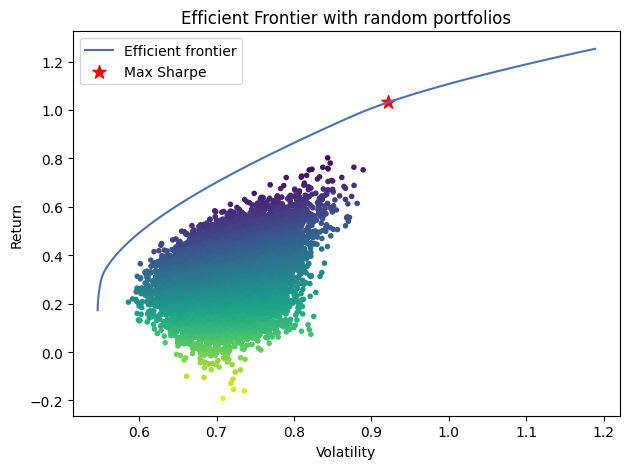

In [9]:
markowitz.plot_frontier()

In [10]:
from portfolio_optimization.portfolio import weight_diff

diffs = weight_diff(markowitz_weights, hrp_weights, threshold=0.05)
print(len(diffs))
diffs

8


[('ada', 'Buy', 0.05496755786664213),
 ('uni', 'Buy', 0.06635681744972621),
 ('eth', 'Buy', 0.06690902397496665),
 ('matic', 'Sell', 0.15167272559937417),
 ('wbtc', 'Buy', 0.08638964305983773),
 ('bnb', 'Sell', 0.18136916540119338),
 ('btc', 'Sell', 0.14653413710060897),
 ('cake', 'Buy', 0.06878039053272592)]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.3639468199737015e-06
            Iterations: 22
            Function evaluations: 209
            Gradient evaluations: 22


/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(
/Users/arguiot/Developer/Pyratz/portfolio/env/lib/python3.11/site-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfo

The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Skipping rebalance on 2020-10-31 due to insufficient data.
The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Skipping rebalance on 2020-12-31 due to insufficient data.
The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Skipping rebalance on 2021-02-28 due to insufficient data.
The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Skipping rebalance on 2021-04-30 due to insufficient data.
The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Skipping rebalance on 2021-06-30 due to insufficient data.
The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
Skipping rebalance on 2021-08-31 due to insufficient data.
The truth value of a DataFrame is ambiguous. Use a.empty, 

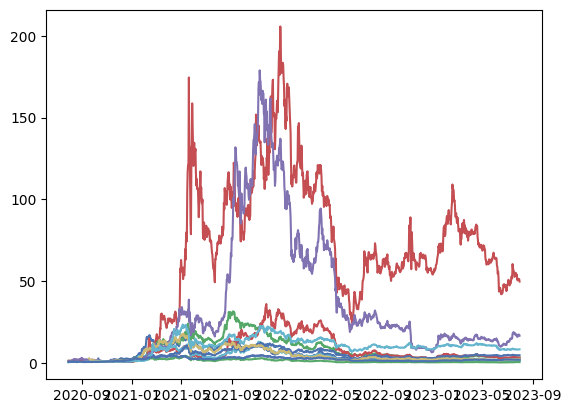

In [11]:
from portfolio_optimization.portfolio.Portfolio import Portfolio
from portfolio_optimization.backtesting.Backtesting import Backtest
from dateutil.relativedelta import relativedelta

# The portfolio starts
start_date_portfolio = df.index[0] + relativedelta(months=3)

initial_bid = 1000

porfolio_hrp = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=HRPOptimization,
)

portfolio_markowitz = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=Markowitz,
)

portfolio_bl = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=BlackLitterman,
    mcaps=mcaps.loc[start_date_portfolio],
)

portfolio_parity = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=RiskParity,
)

portfolio_fast_parity = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=FastRiskParity,
)

portfolio_default = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=Heuristic,
)

portfolio_rtr = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=RewardToRisk,
)

portfolio_vov = Portfolio(
    base_value=initial_bid,
    initial_prices=df.loc[:start_date_portfolio],
    optimiser=VolatilityOfVolatility,
)

backtest = Backtest(
    portfolios={
        "HRP": porfolio_hrp,
        "Markowitz": portfolio_markowitz,
        "BL": portfolio_bl,
        "Risk Parity": portfolio_parity,
        "Fast Risk Parity": portfolio_fast_parity,
        "Heuristic": portfolio_default,
        "Reward to Risk": portfolio_rtr,
        "Volatility of Volatility": portfolio_vov,
    },
    start_date=start_date_portfolio,
    end_date=df.index[-1],
    rebalance_frequency="2M",
    data=df,
    mcaps=mcaps,
)

perfs = backtest.run_backtest(look_back_period=120, look_back_unit="D")

# Plot portfolio value over time using matplotlib
import matplotlib.pyplot as plt

df_normalized = df / df.loc[start_date_portfolio]
plt.plot(df_normalized)


In [12]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output
from ipywidgets import GridBox 

# Calculate the first date of the portfolio. The start date is the minimum date of the portfolio_value DataFrame within the `perfs` object. So we just reduce the perfs object to the portfolio_value DataFrame, and then get the minimum date.
start_date_portfolio = min(performance.portfolio_value['Portfolio Value'].index.min() for performance in perfs)


# Normalize prices of each asset at the start date of the portfolio
df_normalized = df / df.loc[start_date_portfolio]

# Calculate the daily equal-weighted return  
# df['equal_weighted'] = df_normalized.mean(axis=1)

# Normalize our portfolio and equally-weighted series to 100 at the start date of the portfolio
portfolio_normalized = pd.concat({performance.name: performance.portfolio_value['Portfolio Value'].loc[start_date_portfolio:] for performance in perfs}, axis=1)

# convert the index to a list of dates, which will be used for the Slider
_dates = [date for performance in perfs for date in performance.portfolio_value['Portfolio Value'].index]
dates = list(dict.fromkeys(_dates))
_rebalance_dates = [rebalance_date for performance in perfs for rebalance_date in performance.rebalance_dates if rebalance_date >= start_date_portfolio]
rebalance_dates = list(dict.fromkeys(_rebalance_dates))

In [13]:
# create a function to update the chart
def update(rebalance_date_index, main_portfolio=0):
    clear_output(wait=True)
        
    selected_date = rebalance_dates[rebalance_date_index]
    
    # Adjust the date_index to the closest rebalance date
    date_index = dates.index(selected_date)
    
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(2, 2)

    ax1 = plt.subplot(gs[1, 0]) # for you normalized performance comparison
    ax3 = plt.subplot(gs[0, 0]) # put the ax1 graph below
    ax4 = plt.subplot(gs[:, 1]) # add a new bar graph showing the backtest.portfolio_holdings on the left of ax2
    ax2 = plt.subplot(gs[0, 1]) # for your pie chart of portfolio composition

    # plot portfolio values on ax1
    portfolio_names = list(p.name for p in perfs)
    ax1.plot(portfolio_normalized.index, portfolio_normalized, label=portfolio_names)
    
    for rebalance_date in rebalance_dates:
        if rebalance_date >= start_date_portfolio:
            ax1.axvline(x=rebalance_date, color='gray', linestyle='--')  

    ax1.axvline(x=selected_date, color='blue', linestyle='-')  # the selected date bar

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Normalized Value")
    ax1.legend()
    ax1.set_title("Performance comparison (selected blue line)")

    # create portfolio composition pie chart on ax2
    selected = perfs[main_portfolio].portfolio_compositions.iloc[rebalance_date_index]
    # filter out rows where value is 0
    selected = selected[selected != 0]

    labels = selected.keys().tolist()
    sizes = selected.replace(np.nan, 0).tolist()

    ax2.pie(sizes, labels=labels)
    ax2.set_title(str(dates[date_index]))

    portfolio_value = perfs[main_portfolio].portfolio_holdings.iloc[rebalance_date_index] * df.loc[selected_date]


    # plot portfolio_value instead of portfolio_holdings
    portfolio_value.plot(ax=ax3, kind='bar')
    ax3.set_title('Portfolio Value in Dollars')

    plt.show()

# create a slider for dates
date_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=len(rebalance_dates)-1 if len(rebalance_dates) > 0 else 0,
    step=1,
    description='Date Index:',
    continuous_update=True
)

pf_index = widgets.Dropdown(
    options=[(p.name, i) for i, p in enumerate(perfs)],
    value=0,
    description='Portfolio:',
    disabled=False,
)


# link the date_slider to the update function
widgets.interactive(update, rebalance_date_index=date_slider, main_portfolio=pf_index)

interactive(children=(IntSlider(value=0, description='Date Index:', max=16), Dropdown(description='Portfolio:'…

# Portfolio Rating
> Using Sharpe ratio to evaluate the performance of a portfolio

In [14]:
returns = portfolio_normalized.pct_change().apply(lambda x: np.log(1+x))


mean_returns = returns.mean()
std_returns = returns.std()

# Assume a risk free rate of 0.01, though this could be any risk free rate of your choice
risk_free_rate = 0.054

#  Calculate the Sharpe Ratio for each asset
sharpe_ratios = (mean_returns - risk_free_rate) / std_returns

# Sort the assets by their sharpe ratios
ranked_assets = sharpe_ratios.sort_values(ascending=False)

ranked_assets

Markowitz                  -0.987738
Risk Parity                -1.057478
Heuristic                  -1.124837
Volatility of Volatility   -1.131922
Reward to Risk             -1.171955
HRP                        -1.225406
Fast Risk Parity           -1.248042
BL                         -1.287323
dtype: float64